<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
由 <a href="https://sebastianraschka.com">Sebastian Raschka</a> 撰写的 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> 一书的补充代码<br>
<br>代码仓库：<a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 比较不同的高效多头注意力实现

本notebook对应用于decoder-style形式的LLMs模型，如GPT、Llama等中的因果多头注意力不同实现进行对比

In [1]:
import torch

torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")

batch_size = 8
context_len = 1024
embed_dim = 768
embeddings = torch.randn((batch_size, context_len, embed_dim), device=device)

PyTorch version: 2.5.1+cu121


- 为了运行本notebook中的所有代码，请确保PyTorch版本在2.5以上；FlexAttention功能在早期版本的PyTorch中不支持
- 如果上面代码cell输出显示PyTorch版本低于2.5，可以用过取消以下注释进行升级；注意2.5版本以上的PyTorch需要Python 3.9或更好的版本
- 有关更具体的安装指南和CUDA版本信息，请参考官方安装指南：https://pytorch.org

In [ ]:
# pip install --upgrade torch torchvision torchaudiu

<br>
&nbsp;

## 1) 基于第三章中的因果注意力的MHA包装类

In [3]:
import torch.nn as nn


class CausalAttention(nn.Module):
    def __init__(self, d_in: int, d_out: int, content_length: int, dropout: float, qkv_bias: bool = False) -> None:
        super().__init__()
        self.d_out = d_out
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(content_length, content_length), diagonal=1))  # 上三角掩码，用于实现因果注意力计算
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, num_tokens, d_in = x.shape
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        
        attn_scores = q @ k.transpose(1, 2)
        attn_scores.masked_fill_(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vector = attn_weights @ v
        return context_vector
    

class Ch03_MHA_Wrapper(nn.Module):
    def __init__(self, d_in: int, d_out: int, content_length: int, dropout: float, num_heads: int, qkv_bias: bool = False) -> None:
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, content_length, dropout, qkv_bias) for _ in range(num_heads)]
        )
        self.out_proj = nn.Linear(d_out*num_heads, d_out*num_heads)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = torch.cat([head(x) for head in self.heads], dim=-1)
        context_vector = self.out_proj(out)
        return context_vector


mha_ch03_wrapper = Ch03_MHA_Wrapper(
    d_in=embed_dim,
    d_out=embed_dim//12,  # 注意，此处是整除了注意力头数
    content_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_ch03_wrapper(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 2) 第三章中的多头注意力实现

In [ ]:
class Ch03_NHA(nn.Module):
    def __init__(self, d_in: int, d_out: int, content_length: int, dropout: float, num_heads: int, qkv_bias: bool = False) -> None:
        super().__init__()
        assert d_in % num_heads == 0, "d_in must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.tril(torch.ones(content_length, content_length), diagonal=1))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, num_tokens, d_in = x.shape

        q = self.W_q(x)  # shape: (b, num_tokens, d_out)
        k = self.W_k(x)
        v = self.W_v(x)
        
        # 将数值矩阵隐式分割一个数值为num_heads的维度，即将最后一个维度展开，(b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        q = q.view(b, num_tokens, self.num_heads, self.head_dim)
        k = k.view(b, num_tokens, self.num_heads, self.head_dim)
        v = v.view(b, num_tokens, self.num_heads, self.head_dim)
        
        # 将q、k、v的第一个、第二个维度进行转置，(b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        q = q.transpose(1, 2)
        k = k.transpose(1, 2)
        v = v.transpose(1, 2)
        
        # 计算注意力权重
        attn_scores = q @ k.transpose(2, 3)

        # 将原始的mask矩阵截断至tokens长度，并转换为布尔类型
        mask = self.mask.bool()[:num_tokens, :num_tokens]

        # 使用mask矩阵对注意力权重进行掩码
        attn_scores.masked_fill_(mask, -torch.inf)

        # 使用softmax函数计算注意力权重
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        
        # shape: (b, num_heads, num_tokens, head_dim) -> (b, num_tokens, num_heads, head_dim)
        context_vector = (attn_weights @ v).transpose(1, 2)

        # 将context_vector的最后一个维度进行展平，(b, num_tokens, num_heads, head_dim) -> (b, num_tokens, num_heads * head_dim)
        context_vector = context_vector.contiguous().view(b, num_tokens, self.d_out)

        # 使用线性层将context_vector的维度转换为d_out
        context_vector = self.out_proj(context_vector)
        
        return context_vector


mha_ch03 = Ch03_NHA(
    d_in=embed_dim,
    d_out=embed_dim,  # 注意，此处是没有整除注意力头数
    content_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False).to(device)

out = mha_ch03(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 3) 一种使用组合权重的替代多头注意力实现
- 以下的MultiHeadAttentionCombinedQKV类代码由[Rayed Bin Wahed](https://github.com/rasbt/LLMs-from-scratch/discussions/51)友情分享。
- MultiHeadAttentionCombinedQKV 类和第三章中使用的 MultiHeadAttention 类之间的主要区别在于，MultiHeadAttentionCombinedQKV 使用单个权重矩阵 self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)，而不是使用独立的权重矩阵。

  - `self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)`
  - `self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)`
  - `self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)`

- 在这里，self.qkv 将三个权重矩阵 self.W_query、self.W_key 和 self.W_value 合并在一起，以在单个步骤中完成查询（query）、键（key）和值（value）的计算
- 通过使用 q, k, v = qkv.unbind(0)，获取到单独的查询、键和值张量，这些张量的使用方式与第三章中 MultiHeadAttention 类中的查询、键和值张量类似

In [ ]:
class MultiHeadAttentionCombinedQKV(nn.Module):
    def __init__(self, d_in: int, d_out: int, content_length: int, dropout: float, num_heads: int, qkv_bias: bool = False) -> None:
        super().__init__()
        assert d_in % num_heads == 0, "d_in must be divisible by num_heads"

        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.content_length = content_length

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        
        self.register_buffer("mask", torch.tril(torch.ones(content_length, content_length), diagonal=1))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, num_tokens, embed_dim = x.shape

        # (batch_size, num_tokens, embed_dim) -> (batch_size, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (batch_size, num_tokens, 3 * embed_dim) -> (batch_size, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (batch_size, num_tokens, 3, num_heads, head_dim) -> (3, batch_size, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, batch_size, num_heads, num_tokens, head_dim) -> 3 times (batch_size, num_heads, num_tokens, head_dim)
        q, k, v = qkv.unbind(0)

        # 计算注意力权重 (batch_size, num_heads, num_tokens, head_dim) -> (batch_size, num_heads, num_tokens, num_tokens)
        attn_scores = q @ k.transpose(2, 3)

        # 使用mask矩阵对注意力权重进行掩码
        attn_scores = attn_scores.masked_fill(self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)

        # 使用softmax函数计算注意力权重
        attn_weights = torch.softmax(attn_scores / k.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # (batch_size, num_heads, num_tokens, num_tokens) @ (batch_size, num_heads, num_tokens, head_dim) -> (batch_size, num_tokens, num_heads, head_dim)
        context_vector = (attn_weights @ v).transpose(1, 2)

        # 将context_vector的最后一个维度进行展平，(batch_size, num_tokens, num_heads, head_dim) -> (batch_size, num_tokens, num_heads * head_dim)
        context_vector = context_vector.contiguous().view(batch_size, num_tokens, embed_dim)

        # 使用线性层将context_vector的维度转换为d_out
        context_vector = self.out_proj(context_vector)
        
        return context_vector


mha_combined_qkv = MultiHeadAttentionCombinedQKV(
    d_in=embed_dim,
    d_out=embed_dim,
    content_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False).to(device)

out = mha_combined_qkv(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 4) 使用Einsum的MHA实现

- 通过 [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html) 使用爱因斯坦求和实现多头注意力机制

In [10]:
import math


class MHAEinsum(nn.Module):

    def __init__(self, d_in: int, d_out: int, context_length: int, dropout: float, num_heads: int, qkv_bias: bool = False) -> None:
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads

        # 初始化Q、K、V的权重
        self.W_query = nn.Parameter(torch.randn(d_out, d_in))
        self.W_key = nn.Parameter(torch.randn(d_out, d_in))
        self.W_value = nn.Parameter(torch.randn(d_out, d_in))

        if qkv_bias:  # 初始化偏置
            self.bias_q = nn.Parameter(torch.zeros(d_out))
            self.bias_k = nn.Parameter(torch.zeros(d_out))
            self.bias_v = nn.Parameter(torch.zeros(d_out))
        else:
            self.register_parameter("bias_q", None)
            self.register_parameter("bias_k", None)
            self.register_parameter("bias_v", None)

        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1))

        # 初始化参数
        self.reset_parameters()


    def reset_parameters(self) -> None:
        nn.init.kaiming_uniform_(self.W_query, a=math.sqrt(5))  # 使用Kaiming初始化
        nn.init.kaiming_uniform_(self.W_key, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_value, a=math.sqrt(5))
        if self.bias_q is not None:  # 手动初始化偏置
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.W_query)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias_q, -bound, bound)
            nn.init.uniform_(self.bias_k, -bound, bound)
            nn.init.uniform_(self.bias_v, -bound, bound)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        b, n, _ = x.shape

        # 使用einsum计算Q、K、V，首先进行线性变换
        Q = torch.einsum("bnd,di->bni", x, self.W_query)
        K = torch.einsum("bnd,di->bni", x, self.W_key)
        V = torch.einsum("bnd,di->bni", x, self.W_value)

        # 如果使用偏置，则添加偏置
        if self.bias_q is not None:
            Q += self.bias_q
            K += self.bias_k
            V += self.bias_v

        # 将Q、K、V的维度转换为多头注意力
        Q = Q.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(b, n, self.num_heads, self.head_dim).transpose(1, 2)

        # 缩放点积注意力
        scores = torch.einsum("bhnd,bhmd->bhnm", Q, K) / (self.head_dim ** 0.5)

        # 应用掩码
        mask = self.mask[:n, :n].unsqueeze(0).unsqueeze(1).expand(b, self.num_heads, n, n)
        scores = scores.masked_fill(mask.bool(), -torch.inf)

        # 使用softmax函数计算注意力权重
        attn_weights = torch.softmax(scores, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # 聚合上下文向量
        context_vec = torch.einsum("bhnm,bhmd->bhnd", attn_weights, V)

        # 将多头注意力聚合为单个输出
        context_vec = context_vec.transpose(1, 2).reshape(b, n, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec


mha_einsum = MHAEinsum(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_einsum(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 5) 使用 PyTorch 的缩放点积注意力和 FlashAttention 实现多头注意力
- 下面的实现使用了 PyTorch 的 [`scaled_dot_product_attention`](https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html) 函数，该函数实现了一种称为 [FlashAttention](https://arxiv.org/abs/2205.14135) 的内存优化版本自注意力机制

In [11]:
class MHAPyTorchScaledDotProduct(nn.Module):
    def __init__(self, d_in: int, d_out: int, num_heads: int, context_length: int, dropout: float = 0.0, qkv_bias: bool = False) -> None:
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout  # 如果训练，则使用dropout

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=None, dropout_p=use_dropout, is_causal=True)  # 使用torch中的缩放点积注意力

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec


mha_pytorch_scaled = MHAPyTorchScaledDotProduct(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_scaled(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 6) 不使用 FlashAttention的PyTorch 的缩放点积注意力
- 这与上面的实现类似，只是我们通过传递一个显式的因果掩码来禁用FlashAttention


In [12]:
class MHAPyTorchSDPAWithoutFlash(nn.Module):
    def __init__(self, d_in: int, d_out: int, num_heads: int, context_length: int, dropout: float = 0.0, qkv_bias: bool = False) -> None:
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        use_dropout = 0. if not self.training else self.dropout

        # 确保 attn_mask 与预期形状兼容并设置 batch_first=True
        # 无需手动调整 num_heads；确保其对序列是正确的
        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        context_vec = nn.functional.scaled_dot_product_attention(
            queries, keys, values, attn_mask=attn_mask, dropout_p=use_dropout, is_causal=False)  # 传入mask，禁用FlashAttention

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec


mha_pytorch_sdpa_no_flash = MHAPyTorchSDPAWithoutFlash(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_sdpa_no_flash(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 7) 使用PyTorch的 torch.nn.MultiheadAttention
- 以下, 使用PyTorch的[torch.nn.MultiheadAttention](https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html)来实现

In [13]:
class MHAPyTorchClass(nn.Module):
    def __init__(self, d_in: int, d_out: int, num_heads: int, context_length: int, dropout: float = 0.0, qkv_bias: bool = False, need_weights: bool = True) -> None:
        super().__init__()

        self.context_length = context_length
        self.multihead_attn = nn.MultiheadAttention(
            embed_dim=d_out,
            num_heads=num_heads,
            dropout=dropout,
            bias=qkv_bias,
            add_bias_kv=qkv_bias,
            batch_first=True,
        )

        self.need_weights = need_weights
        self.proj = nn.Linear(d_out, d_out)
        self.register_buffer("mask", torch.triu(torch.ones(context_length, context_length), diagonal=1).bool())

    def forward(self, x):
        batch_size, num_tokens, _ = x.shape

        if self.context_length >= num_tokens:
            attn_mask = self.mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.mask[:self.context_length, :self.context_length]

        # attn_mask 广播机制将隐式处理 batch_size 维度
        attn_output, _ = self.multihead_attn(
            x, x, x, attn_mask=attn_mask, need_weights=self.need_weights
        )

        output = self.proj(attn_output)

        return output


mha_pytorch_class_default = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False
).to(device)

out = mha_pytorch_class_default(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 8) 使用PyTorch的 torch.nn.MultiheadAttention 和 `scaled_dot_product_attention`一起实现
- 将 need_weights（默认为 True）设置为 False，这样 MultiheadAttention 将使用 scaled_dot_product_attention，根据[文档](https://github.com/pytorch/pytorch/blob/71d020262793542974cf13b30f2a9099773f015c/torch/nn/modules/activation.py#L1096)所述

```markdown
need_weights: 如果指定，除了返回attn_outputs外，还返回attn_output_weights。
              设置need_weights=False可以使用优化的scaled_dot_product_attention，并实现MHA的最佳性能。
              默认值：True
```


In [14]:
mha_pytorch_class_noweights = MHAPyTorchClass(
    d_in=embed_dim,
    d_out=embed_dim,
    context_length=context_len,
    dropout=0.0,
    num_heads=12,
    qkv_bias=False,
    need_weights=False # NEW!
).to(device)

out = mha_pytorch_class_noweights(embeddings)
print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 9) 使用PyTorch的 FlexAttention实现

- 查看[FlexAttention: The Flexibility of PyTorch with the Performance of FlashAttention](https://pytorch.org/blog/flexattention/)了解更多关于FlexAttention的信息
- FlexAttention 的缺点：它目前不支持 dropout
- 从 PyTorch 2.5 开始支持，可以在 CPU 机器上安装，通过以下命令：

    ```bash
    pip install torch torchvision torchaudio
    ```

- 在 GPU 机器上安装 PyTorch，使用以下命令（更多信息，请参见 [pytorch.org](https://pytorch.org/)）

    ```bash
    pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124
    ```

In [16]:
from packaging.version import parse as parse_version

def normalize_version(version):
    parsed_version = parse_version(version)
    return parse_version(f"{parsed_version.major}.{parsed_version.minor}.{parsed_version.micro}")

current_version = normalize_version(torch.__version__)
print(current_version)
MIN_TORCH_VERSION = "2.5.0"
required_version = parse_version(MIN_TORCH_VERSION)

2.5.1


In [17]:
if current_version >= required_version and torch.cuda.is_available():
    from torch.nn.attention.flex_attention import flex_attention, create_block_mask


def causal(b, h, q_idx, kv_idx):
    return q_idx >= kv_idx


class MHAPyTorchFlexAttention(nn.Module):

    def __init__(self, d_in, d_out, num_heads, context_length, dropout=0.0, qkv_bias=False):
        super().__init__()

        assert d_out % num_heads == 0, "embed_dim is indivisible by num_heads"

        self.num_heads = num_heads
        self.context_length = context_length
        self.head_dim = d_out // num_heads
        self.d_out = d_out

        self.qkv = nn.Linear(d_in, 3 * d_out, bias=qkv_bias)
        self.proj = nn.Linear(d_out, d_out)
        self.dropout = dropout
        # self.register_buffer("block_mask", create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length))
        # create_block_mask 函数目前尚不支持缓冲区
        self.block_mask = create_block_mask(causal, B=None, H=None, Q_LEN=context_length, KV_LEN=context_length)


    def forward(self, x):
        batch_size, num_tokens, embed_dim = x.shape

        # (b, num_tokens, embed_dim) --> (b, num_tokens, 3 * embed_dim)
        qkv = self.qkv(x)

        # (b, num_tokens, 3 * embed_dim) --> (b, num_tokens, 3, num_heads, head_dim)
        qkv = qkv.view(batch_size, num_tokens, 3, self.num_heads, self.head_dim)

        # (b, num_tokens, 3, num_heads, head_dim) --> (3, b, num_heads, num_tokens, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)

        # (3, b, num_heads, num_tokens, head_dim) -> 3 times (b, num_heads, num_tokens, head_dim)
        queries, keys, values = qkv

        # use_dropout = 0. if not self.training else self.dropout  # 不支持dropout

        if self.context_length >= num_tokens:
            attn_mask = self.block_mask[:num_tokens, :num_tokens]
        else:
            attn_mask = self.block_mask[:self.context_length, :self.context_length]

        context_vec = flex_attention(queries, keys, values, block_mask=attn_mask)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.transpose(1, 2).contiguous().view(batch_size, num_tokens, self.d_out)

        context_vec = self.proj(context_vec)

        return context_vec


if current_version >= required_version and torch.cuda.is_available():

    mha_pytorch_flex = MHAPyTorchFlexAttention(
        d_in=embed_dim,
        d_out=embed_dim,
        context_length=context_len,
        dropout=0.0,
        num_heads=12,
        qkv_bias=False
    ).to(device)

    out = mha_pytorch_flex(embeddings)
    print(out.shape)

torch.Size([8, 1024, 768])


<br>
&nbsp;

## 快速速度比较 (Intel(R) Xeon(R) Gold 6330 CPU @ 2.00GHz)

In [19]:
torch.manual_seed(123)
device = torch.device("cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.5.1+cu121
Running on cpu


In [20]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mha_ch03_wrapper(embeddings)

8 ms ± 8.19 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

6.46 ms ± 9.51 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

7.24 ms ± 4.97 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
## 4) Multi-head attention using Einstein summation
%timeit mha_einsum(embeddings)

7.68 ms ± 4.57 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
## 5) Multi-head attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

3.61 ms ± 2.8 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [25]:
## 6) PyTorch's scaled dot product attention without FlashAttention
%timeit mha_pytorch_sdpa_no_flash(embeddings)

5.36 ms ± 9.56 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
## 7) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

6.84 ms ± 6.63 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [27]:
## 8) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

6.18 ms ± 8.09 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
## 9) Using PyTorch's FlexAttention

# Requires PyTorch 2.5.0 or newer and currently only supports CUDA PyTorch
%timeit mha_pytorch_flex(embeddings)

16.5 ms ± 55.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<br>
&nbsp;

## 快速速度比较 (Nvidia 3090 Ti)

In [29]:
# 启用张量核心
torch.set_float32_matmul_precision("high")

In [30]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.5.1+cu121
Running on cuda


In [31]:
## 1) CausalAttention MHA wrapper class from chapter 3
%timeit mha_ch03_wrapper(embeddings)

5.92 ms ± 3.02 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
## 2) The multi-head attention class from chapter 3
%timeit mha_ch03(embeddings)

5.32 ms ± 3.26 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
## 3) An alternative multi-head attention with combined weights
%timeit mha_combined_qkv(embeddings)

6 ms ± 3.93 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [35]:
## 4) Multi-head attention using Einstein summation
%timeit mha_einsum(embeddings)

6.65 ms ± 6.02 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [36]:
## 5) Multi-head attention with PyTorch's scaled dot product attention
%timeit mha_pytorch_scaled(embeddings)

2.92 ms ± 5.64 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
## 6) PyTorch's scaled dot product attention without FlashAttention
%timeit mha_pytorch_sdpa_no_flash(embeddings)

4.7 ms ± 3.51 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [38]:
## 7) Using PyTorch's torch.nn.MultiheadAttention
%timeit mha_pytorch_class_default(embeddings)

5.66 ms ± 418 ns per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
## 8) Using PyTorch's torch.nn.MultiheadAttention disabling `need_weights`
%timeit mha_pytorch_class_noweights(embeddings)

5.52 ms ± 1.08 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
## 9) Using PyTorch's FlexAttention

# Requires PyTorch 2.5.0 or newer
%timeit mha_pytorch_flex(embeddings)

15.1 ms ± 189 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<br>
&nbsp;


# 可视化

In [41]:
torch.manual_seed(123)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"PyTorch version: {torch.__version__}")
print(f"Running on {device}")

PyTorch version: 2.5.1+cu121
Running on cuda


In [42]:
functions = {
    "1) MHA wrapper class": mha_ch03_wrapper,
    "2) MHA Ch03": mha_ch03,
    "3) MHA with combined QKV weights": mha_combined_qkv,
    "4) MHA with Einsum": mha_einsum,
    "5) MHA with PyTorch scaled_dot_product_attention": mha_pytorch_scaled,
    "6) PyTorch's SDPA, no FlashAttention": mha_pytorch_sdpa_no_flash,
    "7) PyTorch MHA class defaults": mha_pytorch_class_default,
    "8) PyTorch MHA with need_weights=False": mha_pytorch_class_noweights
    }

if current_version >= required_version and torch.cuda.is_available():
    functions["9) PyTorch's FlexAttention"] =  mha_pytorch_flex

In [43]:
import matplotlib.pyplot as plt

# Customize further for dark mode aesthetics
plt.rcParams["figure.facecolor"] = "#121212"
plt.rcParams["axes.facecolor"] = "#121212"
plt.rcParams["axes.edgecolor"] = "white"
plt.rcParams["axes.labelcolor"] = "white"
plt.rcParams["text.color"] = "white"
plt.rcParams["xtick.color"] = "white"
plt.rcParams["ytick.color"] = "white"
plt.rcParams["grid.color"] = "#444444"
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8


def plot_execution_times(functions, execution_means, execution_stds, filename):

    # Create plot
    fig, ax = plt.subplots()
    bars = ax.bar(functions.keys(), execution_means, yerr=execution_stds, capsize=5, error_kw={'ecolor': 'grey'})

    plt.ylabel("Execution time (ms)")
    plt.xticks(rotation=45, ha="right")

    # Calculate new ylim with a margin
    max_execution_time = max(execution_means)
    upper_ylim = max_execution_time + 0.4 * max_execution_time  # Adding a 40% margin
    plt.ylim(0, upper_ylim)

    # Annotate bars with execution times
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + (0.05 * upper_ylim), round(yval, 2), ha="center", va="bottom")

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

## 带预热的速度比较（仅前向传播，在 Nvidia 3090 Ti GPU 上测试）

In [44]:
# CUDA benchmark code shared by Andrei Aksionov
# and based on code from
# https://github.com/cuda-mode/lectures/blob/main/lecture1/pytorch_square.py

import numpy as np


def time_pytorch_function(func, *input, num_repeats=1_000):
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        func(*input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        func(*input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

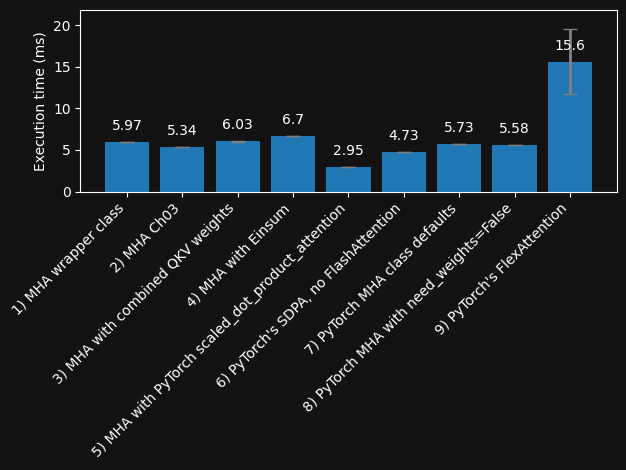

In [45]:
execution_stats = [time_pytorch_function(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]

plot_execution_times(functions, execution_means, execution_stds, filename="1_forward-only.pdf")

<br>
&nbsp;


## 带预热的速度比较（前向和反向传播，在 Nvidia 3090 Ti GPU 上测试）

In [46]:
def forward_backward(func, embeddings):
    if embeddings.grad is not None:
        embeddings.grad.zero_()

    output = func(embeddings)
    loss = output.sum()
    loss.backward()


def time_pytorch_function_forward_backward(func, *input, num_repeats = 1_000):
    # CUDA IS ASYNC so can't use python time module
    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)

    # Warmup
    for _ in range(5):
        forward_backward(func, *input)
    torch.cuda.synchronize()

    times = []
    for _ in range(num_repeats):
        start.record()
        forward_backward(func, *input)
        end.record()
        torch.cuda.synchronize()
        times.append(start.elapsed_time(end))

    return np.mean(times), np.std(times)

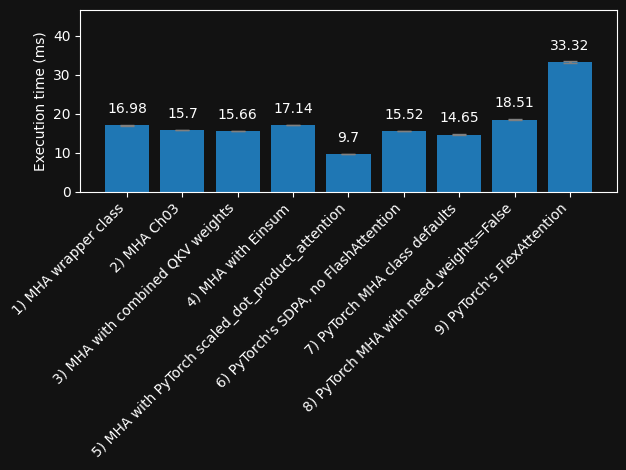

In [47]:
execution_stats = [time_pytorch_function_forward_backward(fn, embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="2_forward-and-backward.pdf")

<br>
&nbsp;


## 带预热和编译的速度比较（前向和反向传播，在 Nvidia 3090 Ti GPU 上测试）

In [48]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True


def prepare_function(fn):
    fn = torch.compile(fn)
    return fn

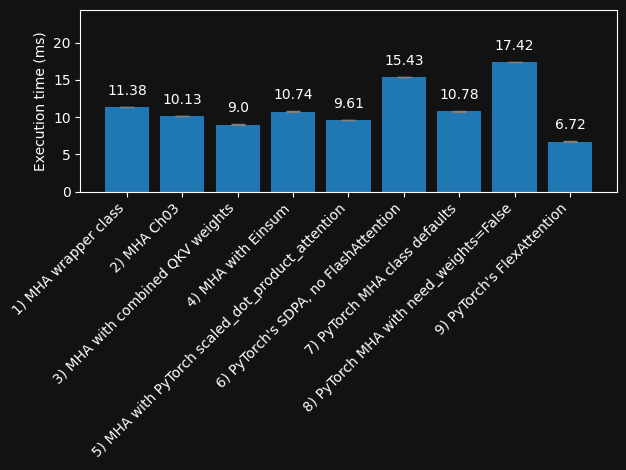

In [49]:
execution_stats = [time_pytorch_function_forward_backward(prepare_function(fn), embeddings) for fn in functions.values()]
execution_means = [stat[0] for stat in execution_stats]
execution_stds = [stat[1] for stat in execution_stats]


plot_execution_times(functions, execution_means, execution_stds, filename="3_forward-and-backward-compiled.pdf")